In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re 
import ast
import warnings
warnings.filterwarnings('ignore')

# Compute accuracy

In [2]:
# Define the file path for human ratings dataset
human_ratings_path = "../data/explica/explica_freq_4800.tsv"

# Load the human ratings dataset into a pandas DataFrame
human_ratings = pd.read_csv(human_ratings_path, sep=",")
# Sort the dataset based on multiple columns to ensure a consistent order
# Sorting by 'pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', and 'tested_order'
# helps in maintaining consistency for further analysis
human_ratings = human_ratings.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order'])



In [3]:
import ast
import pandas as pd

def get_model_max_rating_cat(batch_df_sub, desc):
    """
    Determines the connective (word/phrase linking sentences) chosen by humans and models based on different rating criteria.
    
    Parameters:
        batch_df_sub (pd.DataFrame): Subset of the dataset containing sentence pairs and ratings.
        desc (str): Description specifying the evaluation method ('acc' for acceptability, 'mc' for multiple choice, 
                    'perpl' for perplexity, 'cloze' for cloze test).
    
    Returns:
        pd.DataFrame: Updated DataFrame with the human and model-chosen connectives.
    """
    
    # Assign the connective preferred by humans (from precomputed data)
    batch_df_sub['human_chosen_connective'] = batch_df_sub['human_preferred_connective_unrel']

    ##### COMPUTE THE CONNECTIVE CHOSEN BY MODELS
    # Acceptability-Based Selection
    if "acc" in desc:  # Select the connective with the highest rating
        batch_df_sub['model_chosen_connective'] = batch_df_sub.groupby('pair_id')['generated_answer_outlines'].transform(
            lambda x: batch_df_sub.loc[x.idxmax(), 'tested_connective']
        )

    # Multiple Choice-Based Selection
    elif "mc" in desc:  # Map the model-generated answer to the corresponding choice in the dictionary
        generated = batch_df_sub["generated_answer_outlines"].tolist()
        choices = [eval(x) for x in batch_df_sub["answers_dict"].tolist()]
        chosen_connective = []
        
        for generation, ans_dict in zip(generated, choices):
            if generation not in ans_dict:
                chosen_connective.append("error")  # Handle cases where the model's choice is not found
            else:
                chosen_connective.append(ans_dict[generation])
        
        batch_df_sub["model_chosen_connective"] = chosen_connective

    # Perplexity-Based Selection
    elif "perpl" in desc:  # Select the connective corresponding to the lowest perplexity ranking
        batch_df_sub['model_chosen_connective'] = batch_df_sub.groupby('pair_id')['rank'].transform(
            lambda x: batch_df_sub.loc[x.idxmin(), 'tested_connective']
        )

    # Cloze Test-Based Selection
    elif "cloze" in desc:  # Directly take the model-generated answer
        batch_df_sub['model_chosen_connective'] = batch_df_sub['generated_answer_outlines']
    
    # Remove duplicate rows to ensure uniqueness
    batch_df_sub_unique = batch_df_sub.drop_duplicates()
    
    return batch_df_sub_unique


def split_sentence_pairs(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataset into two DataFrames based on different sentence orders.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing sentence pairs.
    
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: Two DataFrames representing different sentence orders.
    """
    
    # Group by sentence pair identifier
    grouped = df.groupby("pair_id")

    df_order_1 = []
    df_order_2 = []

    for _, group in grouped:
        if len(group) == 8:  # Ensuring that each pair appears exactly 8 times (4 per order)
            order_1 = group.iloc[:4]  # First 4 rows for one order
            order_2 = group.iloc[4:]  # Last 4 rows for the reverse order
            df_order_1.append(order_1)
            df_order_2.append(order_2)

    # Concatenating results into two separate DataFrames
    df_order_1 = pd.concat(df_order_1)
    df_order_2 = pd.concat(df_order_2)

    return df_order_1, df_order_2


def clean_compute_max(batch_df, desc):
    """
    Prepares and processes the dataset to determine the most preferred connective for each sentence pair.
    
    Parameters:
        batch_df (pd.DataFrame): The full dataset containing sentence pairs and model predictions.
        desc (str): Description specifying the evaluation method.
    
    Returns:
        pd.DataFrame: Final dataset sorted by pair_id, containing model-selected connectives.
    """

    # Split the dataset into two groups based on different sentence orders
    batch_df_order_1, batch_df_order_2 = split_sentence_pairs(batch_df)
    
    # Compute the preferred connective for each order
    batch_df_BA_unique = get_model_max_rating_cat(batch_df_order_1, desc)
    batch_df_AB_unique = get_model_max_rating_cat(batch_df_order_2, desc)
    
    # Combine the results
    batches = [batch_df_AB_unique, batch_df_BA_unique]
    df = pd.concat(batches)
    
    # Sort results by pair_id for consistency
    df = df.sort_values(['pair_id'])
    
    return df


In [4]:

def compute_accuracy(desc, _dict, accuracies, human_ratings):
    print("****", desc)
    for model, path in _dict.items():
        print(model)
        df_curr = pd.read_csv(path, sep = "\t")

        # PREPARE RESULT DICT WITH ACCURACIES
        key = desc+"_"+model
        accuracies[key] = dict()
        
        # UNIFORMO I DF
        if "mc" in desc: # IN MULTIPLE CHOICE L'ORDINE è ESPRESSO DIVERSAMENTE
            order_map = {'<A;B>': "B follows A",'<B;A>': "A follows B", 'none':'none'}
            df_curr['order'] = df_curr['order'].map(order_map)
            
            
        if "relation" in df_curr and "order" in df_curr and "conn_in_list" in df_curr:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'relation', 'order', 'conn_in_list']) 
            df_curr["tested_relation"] = df_curr["relation"]
            del df_curr["relation"]
            df_curr["tested_order"] = df_curr["order"]
            del df_curr["order"]
            df_curr["tested_connective"] = df_curr["conn_in_list"]
            del df_curr["conn_in_list"]
        elif "tested_relation" in df_curr and "tested_order" in df_curr and "tested_connective" in df_curr:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective']) 
        else:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B'])
     
        
        
      
        if "mc" in desc:
            print("MC")
            df_curr = df_curr.drop_duplicates(subset=["Sentence_A", "Sentence_B"], keep="first")
            df_curr_with_human = pd.merge(human_ratings, df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned', 'answers_dict']], how='left', on=['pair_id', 'Sentence_A', 'Sentence_B'])
        elif "cloze" in desc:   
            print("CLOZE")
            df_curr = df_curr.drop_duplicates(subset=["Sentence_A", "Sentence_B"], keep="first")
            df_curr_with_human = pd.merge(human_ratings, df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned']], how='left', on=['pair_id', 'Sentence_A', 'Sentence_B'])
        else:
            df_curr_with_human = pd.merge(df_curr, human_ratings[['pair_id', 'Sentence_A', 'Sentence_B',  'tested_relation', 'tested_order', 'tested_connective', 'order_human', 'relation_human', 'condition_human', 'human_preferred_connective_unrel' ]], how='left', on=['pair_id', 'Sentence_A', 'Sentence_B',  'tested_relation', 'tested_order',  'tested_connective'])
        
        print(desc, df_curr_with_human.shape)
        #print(desc, df_curr_with_human.columns)
        
        df_human_gt = clean_compute_max(df_curr_with_human, desc)
        

        
        # COMPUTE ACCURACY PER CATEGORY
        df_human_gt_caus_AB = df_human_gt[(df_human_gt['order_human'] == "A,B")&(df_human_gt['relation_human'] == "Causal")]
        df_human_gt_temp_AB = df_human_gt[(df_human_gt['order_human'] == "A,B")&(df_human_gt['relation_human'] == "Temporal")]
        df_human_gt_caus_BA = df_human_gt[(df_human_gt['order_human'] == "B,A")&(df_human_gt['relation_human'] == "Causal")]
        df_human_gt_temp_BA = df_human_gt[(df_human_gt['order_human'] == "B,A")&(df_human_gt['relation_human'] == "Temporal")]

        # COMPUTE TOTAL ACCURACY
        total = pd.concat([df_human_gt_caus_AB, df_human_gt_temp_AB, df_human_gt_caus_BA, df_human_gt_temp_BA]) 
        correct = total[(total['human_preferred_connective_unrel'] == total["model_chosen_connective"])].shape[0]
        accuracy_total = correct/total.shape[0]
        accuracies[key]["Overall"] = accuracy_total

        dfs = {
        "Causality AB" : df_human_gt_caus_AB,
        "Temporal AB" : df_human_gt_temp_AB,
        "Causality BA" : df_human_gt_caus_BA,
        "Temporal BA" : df_human_gt_temp_BA,
        }

        for k, v in dfs.items():
            correct = v[(v['human_preferred_connective_unrel'] == v["model_chosen_connective"])].shape[0]
            accuracy = correct/v.shape[0]
            accuracies[key][k] =  accuracy
    return accuracies

In [10]:
import ast
import pandas as pd

def compute_accuracy(desc, _dict, accuracies, human_ratings):
    """
    Compute the accuracy of model predictions compared to human ratings.
    
    Parameters:
        desc (str): Description of the evaluation method ('mc' for multiple choice, 'cloze' for cloze test, etc.).
        _dict (dict): Dictionary mapping model names to file paths.
        accuracies (dict): Dictionary to store computed accuracy values.
        human_ratings (pd.DataFrame): DataFrame containing human ratings.
    
    Returns:
        dict: Updated accuracies dictionary with computed accuracy values.
    """
    print("*** Task:", desc)
    for model, path in _dict.items():
        print("***** Model:", model)
        
        df_curr = pd.read_csv(path, sep="\t")
        
        # Prepare a dictionary to store accuracies for the current model
        key = desc + "_" + model
        accuracies[key] = dict()
        
        # Standardize the dataset format
        if "mc" in desc:  # Multiple-choice format has a different order representation
            order_map = {'<A;B>': "B follows A", '<B;A>': "A follows B", 'none': 'none'}
            df_curr['order'] = df_curr['order'].map(order_map)
            
        # Drop eventual duplicates for multiple-choice and cloze    
        if "mc" in desc or "cloze" in desc:
            df_curr = df_curr.drop_duplicates(subset=["Sentence_A", "Sentence_B"], keep="first")
            
            
        # Sort data and standardize column names for consistency
        if "relation" in df_curr and "order" in df_curr and "conn_in_list" in df_curr:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'relation', 'order', 'conn_in_list']) 
            df_curr["tested_relation"] = df_curr["relation"]
            del df_curr["relation"]
            df_curr["tested_order"] = df_curr["order"]
            del df_curr["order"]
            df_curr["tested_connective"] = df_curr["conn_in_list"]
            del df_curr["conn_in_list"]
        elif "tested_relation" in df_curr and "tested_order" in df_curr and "tested_connective" in df_curr:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective']) 
        else:
            df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B'])
     
        
        
        # Merge with human ratings based on evaluation type
        if "mc" in desc:
            df_curr_with_human = pd.merge(
                human_ratings, 
                df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned', 'answers_dict']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B']
            )
        elif "cloze" in desc:
            df_curr_with_human = pd.merge(
                human_ratings, 
                df_curr[['pair_id', 'Sentence_A', 'Sentence_B', 'generated_answer_outlines', 'answer_greedy_cleaned']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B']
            )
        else:
            df_curr_with_human = pd.merge(
                df_curr, 
                human_ratings[['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective', 'order_human', 'relation_human', 'condition_human', 'human_preferred_connective_unrel']],
                how='left', on=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective']
            )
            
        # Compute accuracy
        df_human_gt = clean_compute_max(df_curr_with_human, desc)
        
        # Filter dataset into different categories based on order and relation
        df_human_gt_caus_AB = df_human_gt[(df_human_gt['order_human'] == "A,B") & (df_human_gt['relation_human'] == "Causal")]
        df_human_gt_temp_AB = df_human_gt[(df_human_gt['order_human'] == "A,B") & (df_human_gt['relation_human'] == "Temporal")]
        df_human_gt_caus_BA = df_human_gt[(df_human_gt['order_human'] == "B,A") & (df_human_gt['relation_human'] == "Causal")]
        df_human_gt_temp_BA = df_human_gt[(df_human_gt['order_human'] == "B,A") & (df_human_gt['relation_human'] == "Temporal")]
        
        # Compute overall accuracy
        total = pd.concat([df_human_gt_caus_AB, df_human_gt_temp_AB, df_human_gt_caus_BA, df_human_gt_temp_BA])
        correct = total[total['human_preferred_connective_unrel'] == total["model_chosen_connective"]].shape[0]
        accuracy_total = correct / total.shape[0]
        accuracies[key]["Overall"] = accuracy_total
        
        # Compute accuracy per category
        dfs = {
            "Causality AB": df_human_gt_caus_AB,
            "Temporal AB": df_human_gt_temp_AB,
            "Causality BA": df_human_gt_caus_BA,
            "Temporal BA": df_human_gt_temp_BA,
        }
        
        for k, v in dfs.items():
            correct = v[v['human_preferred_connective_unrel'] == v["model_chosen_connective"]].shape[0]
            accuracy = correct / v.shape[0]
            accuracies[key][k] = accuracy
    
        
    return accuracies


In [11]:
accuracies = dict()


acc_few_dict = {
    "gpt4omini" : "../data/res/acceptability/fewshot/accept_res_outlines_gpt-4o-mini_few_cleaned.tsv",
"gpt4o" : "../data/res/acceptability/fewshot/accept_res_outlines_gpt-4o_few_cleaned.tsv",    
"falcon" : "../data/res/acceptability/fewshot/accept_res_outlines_falcon-7b-instruct_cleaned.tsv",
"gemma" : "../data/res/acceptability/fewshot/accept_res_outlines_gemma-2-9b-it_cleaned.tsv",
"llama" : "../data/res/acceptability/fewshot/accept_res_outlines_Meta-Llama-3.1-8B-Instruct_cleaned.tsv",
"mistral" : "../data/res/acceptability/fewshot/accept_res_outlines_Mistral-7B-Instruct-v0.3_cleaned.tsv",
"qwen" : "../data/res/acceptability/fewshot/accept_res_outlines_Qwen2.5-7B-Instruct_cleaned.tsv" }


accuracies = compute_accuracy("acc_few", acc_few_dict, accuracies, human_ratings)


###########

acc_zero_dict = {
"gpt4omini" : "../data/res/acceptability/zeroshot/accept_res_outlines_gpt-4o-mini_zero_cleaned.tsv",
"gpt4o" : "../data/res/acceptability/zeroshot/accept_res_outlines_gpt-4o_zero_cleaned.tsv",    
"falcon" : "../data/res/acceptability/zeroshot/accept_res_outlines_falcon-7b-instruct_cleaned.tsv",
"gemma" : "../data/res/acceptability/zeroshot/accept_res_outlines_gemma-2-9b-it_cleaned.tsv",
"llama" : "../data/res/acceptability/zeroshot/accept_res_outlines_Meta-Llama-3.1-8B-Instruct_cleaned.tsv",
"mistral" : "../data/res/acceptability/zeroshot/accept_res_outlines_Mistral-7B-Instruct-v0.3_cleaned.tsv",
"qwen" : "../data/res/acceptability/zeroshot/accept_res_outlines_Qwen2.5-7B-Instruct_cleaned.tsv" }

accuracies = compute_accuracy("acc_zero", acc_zero_dict, accuracies, human_ratings)

###########******* CLOZE TEST TASK

cloze_few_dict = {
    "gpt4omini": "../data/res/cloze/fewshot/cloze_res_outlines_gpt-4o-mini_few_cleaned.tsv",
    "gpt4o": "../data/res/cloze/fewshot/cloze_res_outlines_gpt-4o_few_cleaned.tsv",
    "falcon": "../data/res/cloze/fewshot/cloze_res_outlines_falcon-7b-instruct_cleaned.tsv",
    "gemma": "../data/res/cloze/fewshot/cloze_res_outlines_gemma-2-9b-it_cleaned.tsv",
    "llama": "../data/res/cloze/fewshot/cloze_res_outlines_Meta-Llama-3.1-8B-Instruct_cleaned.tsv",
    "mistral": "../data/res/cloze/fewshot/cloze_res_outlines_Mistral-7B-Instruct-v0.3_cleaned.tsv",
    "qwen": "../data/res/cloze/fewshot/cloze_res_outlines_Qwen2.5-7B-Instruct_cleaned.tsv"
}

accuracies = compute_accuracy("cloze_few", cloze_few_dict, accuracies, human_ratings)


###########


cloze_zero_dict = {
  "gpt4omini": "../data/res/cloze/zeroshot/cloze_res_outlines_gpt-4o-mini_zero_cleaned.tsv",
    "gpt4o": "../data/res/cloze/zeroshot/cloze_res_outlines_gpt-4o_zero_cleaned.tsv",
    "falcon": "../data/res/cloze/zeroshot/cloze_res_outlines_falcon-7b-instruct_cleaned.tsv",
    "gemma": "../data/res/cloze/zeroshot/cloze_res_outlines_gemma-2-9b-it_cleaned.tsv",
    "llama": "../data/res/cloze/zeroshot/cloze_res_outlines_Meta-Llama-3.1-8B-Instruct_cleaned.tsv",
    "mistral": "../data/res/cloze/zeroshot/cloze_res_outlines_Mistral-7B-Instruct-v0.3_cleaned.tsv",
    "qwen": "../data/res/cloze/zeroshot/cloze_res_outlines_Qwen2.5-7B-Instruct_cleaned.tsv"
}


accuracies = compute_accuracy("cloze_zero", cloze_zero_dict, accuracies, human_ratings)


###########******* MULTIPLE CHOICE TASK




mc_few_dict = {
     "gpt4omini": "../data/res/mc/fewshot/mult_choice_res_outlines_gpt-4o-mini_few_cleaned.tsv",
    "gpt4o": "../data/res/mc/fewshot/mult_choice_res_outlines_gpt-4o_few_cleaned.tsv",
    "falcon": "../data/res/mc/fewshot/res_multiple_choice-falcon-7b-instruct-connective_cleaned.tsv",
    "gemma": "../data/res/mc/fewshot/res_multiple_choice-gemma-2-9b-it-connective_cleaned.tsv",
    "llama": "../data/res/mc/fewshot/res_multiple_choice-Meta-Llama-3.1-8B-Instruct-connective_cleaned.tsv",
    "mistral": "../data/res/mc/fewshot/res_multiple_choice-Mistral-7B-Instruct-v0.3-connective_cleaned.tsv",
    "qwen": "../data/res/mc/fewshot/res_multiple_choice-Qwen2.5-7B-Instruct-connective_cleaned.tsv"
}

accuracies = compute_accuracy("mc_few", mc_few_dict, accuracies, human_ratings)

########

mc_zero_dict = {
   "gpt4omini": "../data/res/mc/zeroshot/mult_choice_res_outlines_gpt-4o-mini_cleaned.tsv",
    "gpt4o": "../data/res/mc/zeroshot/mult_choice_res_outlines_gpt-4o_cleaned.tsv",
    "falcon": "../data/res/mc/zeroshot/res_multiple_choice-falcon-7b-instruct-connective_cleaned.tsv",
    "gemma": "../data/res/mc/zeroshot/res_multiple_choice-gemma-2-9b-it-connective_cleaned.tsv",
    "llama": "../data/res/mc/zeroshot/res_multiple_choice-Meta-Llama-3.1-8B-Instruct-connective_cleaned.tsv",
    "mistral": "../data/res/mc/zeroshot/res_multiple_choice-Mistral-7B-Instruct-v0.3-connective_cleaned.tsv",
    "qwen": "../data/res/mc/zeroshot/res_multiple_choice-Qwen2.5-7B-Instruct-connective_cleaned.tsv"
}



accuracies = compute_accuracy("mc_zero", mc_zero_dict, accuracies, human_ratings)

###########******* PERPLEXITY

perpl_dict = {
    "falcon": "../data/res/perplexity/falcon-7b-instruct.csv",
    "gemma": "../data/res/perplexity/gemma-2-9b-it.csv",
    "llama": "../data/res/perplexity/Meta-Llama-3.1-8B-Instruct.csv",
    "mistral": "../data/res/perplexity/Mistral-7B-Instruct-v0.3.csv",
    "qwen": "../data/res/perplexity/Qwen2.5-7B-Instruct.csv"

}

accuracies = compute_accuracy("perpl", perpl_dict, accuracies, human_ratings)







*** Task: acc_few
***** Model: gpt4omini
***** Model: gpt4o
***** Model: falcon
***** Model: gemma
***** Model: llama
***** Model: mistral
***** Model: qwen
*** Task: acc_zero
***** Model: gpt4omini
***** Model: gpt4o
***** Model: falcon
***** Model: gemma
***** Model: llama
***** Model: mistral
***** Model: qwen
*** Task: cloze_few
***** Model: gpt4omini
***** Model: gpt4o
***** Model: falcon
***** Model: gemma
***** Model: llama
***** Model: mistral
***** Model: qwen
*** Task: cloze_zero
***** Model: gpt4omini
***** Model: gpt4o
***** Model: falcon
***** Model: gemma
***** Model: llama
***** Model: mistral
***** Model: qwen
*** Task: mc_few
***** Model: gpt4omini
***** Model: gpt4o
***** Model: falcon
***** Model: gemma
***** Model: llama
***** Model: mistral
***** Model: qwen
*** Task: mc_zero
***** Model: gpt4omini
***** Model: gpt4o
***** Model: falcon
***** Model: gemma
***** Model: llama
***** Model: mistral
***** Model: qwen
*** Task: perpl
***** Model: falcon
***** Model: gemm

In [7]:
accuracies

{'acc_few_gpt4omini': {'Overall': 0.6356132075471698,
  'Causality AB': 0.8146341463414634,
  'Temporal AB': 0.6307692307692307,
  'Causality BA': 0.680365296803653,
  'Temporal BA': 0.3597560975609756},
 'acc_few_gpt4o': {'Overall': 0.7830188679245284,
  'Causality AB': 0.8390243902439024,
  'Temporal AB': 0.7961538461538461,
  'Causality BA': 0.7397260273972602,
  'Temporal BA': 0.75},
 'acc_few_falcon': {'Overall': 0.25707547169811323,
  'Causality AB': 0.25365853658536586,
  'Temporal AB': 0.19615384615384615,
  'Causality BA': 0.2876712328767123,
  'Temporal BA': 0.3170731707317073},
 'acc_few_gemma': {'Overall': 0.33254716981132076,
  'Causality AB': 0.375609756097561,
  'Temporal AB': 0.14615384615384616,
  'Causality BA': 0.3287671232876712,
  'Temporal BA': 0.5792682926829268},
 'acc_few_llama': {'Overall': 0.2417452830188679,
  'Causality AB': 0.24390243902439024,
  'Temporal AB': 0.23461538461538461,
  'Causality BA': 0.2465753424657534,
  'Temporal BA': 0.24390243902439024}

## Results averaged for each model

In [8]:
import numpy as np

# Provided data
data = accuracies

# Function to compute the mean and standard deviation for "few" and "zero" tasks per model
def compute_means_and_std(data):
    mean_few = {}
    mean_zero = {}
    std_few = {}
    std_zero = {}
    few = {}
    zero = {}
    
    for key, values in data.items():
        if "7" not in key and "qwen" in key:
            continue
        
        for metric, value in values.items():
            if metric == "Overall":
                if 'perpl' in key:
                    continue
                
                model = key.split('_')[2]  # Extract model name from key
                task_type = key.split('_')[1]  # Extract task type (few/zero)
                
                # Store values for mean and standard deviation calculation
                if task_type == 'few':
                    few.setdefault(model, []).append(value)
                elif task_type == 'zero':
                    zero.setdefault(model, []).append(value)
    
    # Compute mean and standard deviation for each model
    for model in few:
        mean_few[model] = np.mean(few[model])
        std_few[model] = np.std(few[model])
        mean_zero[model] = np.mean(zero[model])
        std_zero[model] = np.std(zero[model])
        
    return mean_few, mean_zero, std_few, std_zero

# Compute means and standard deviations
mean_few, mean_zero, std_few, std_zero = compute_means_and_std(data)

# Display results
print("Mean per model (Few):")
for model, mean in mean_few.items():
    print(f"{model}: {mean:.4f}, Std. Dev: {std_few.get(model, 0):.4f}")

print("\nMean per model (Zero):")
for model, mean in mean_zero.items():
    print(f"{model}: {mean:.4f}, Std. Dev: {std_zero.get(model, 0):.4f}")


Mean per model (Few):
gpt4omini: 0.4980, Std. Dev: 0.1309
gpt4o: 0.7174, Std. Dev: 0.0480
falcon: 0.2461, Std. Dev: 0.0080
gemma: 0.4552, Std. Dev: 0.0870
llama: 0.2535, Std. Dev: 0.0084
mistral: 0.3412, Std. Dev: 0.1107

Mean per model (Zero):
gpt4omini: 0.4281, Std. Dev: 0.0990
gpt4o: 0.6458, Std. Dev: 0.0938
falcon: 0.2740, Std. Dev: 0.0092
gemma: 0.5318, Std. Dev: 0.0284
llama: 0.2669, Std. Dev: 0.0109
mistral: 0.3270, Std. Dev: 0.0746


## Results averaged for each task

In [12]:
# Provided data (dictionary containing accuracy results)
data = accuracies  

# Function to compute mean and standard deviation of accuracies for "few-shot" and "zero-shot" tasks
def compute_means_and_std(data):
    few, zero = {}, {}  # Dictionaries to store values for few-shot and zero-shot models
    
    for key, values in data.items():  # Iterate over accuracy data
        if "7" not in key and "qwen" in key:  
            continue  # Skip entries that contain "qwen" but do not contain "7"

        if "Overall" in values and 'perpl' not in key:  
            # Extract model name and task type from the key (e.g., "acc_few_gpt4o" -> "few", "gpt4o")
            model, task_type = key.split('_')[2], key.split('_')[1]

            # Store "Overall" accuracy values based on task type (few-shot or zero-shot)
            (few if task_type == 'few' else zero).setdefault(model, []).append(values["Overall"])
    
    # Return dictionary containing mean and standard deviation for each model
    return {
        "mean_few": {m: np.mean(v) for m, v in few.items()},
        "std_few": {m: np.std(v) for m, v in few.items()},
        "mean_zero": {m: np.mean(v) for m, v in zero.items()},
        "std_zero": {m: np.std(v) for m, v in zero.items()}
    }

# Compute statistics for few-shot and zero-shot tasks
stats = compute_means_and_std(data)

# Define task categories to analyze
tasks = ["acc_few", "acc_zero", "mc_few", "mc_zero", "cloze_few", "cloze_zero", "perpl"]

# Dictionaries to store accuracies for different task types
best_average_task, best_average_task_nogpt, best_average_task_onlygpt = {}, {}, {}

# Function to categorize accuracies based on task type and whether they use GPT models
def categorize_accuracies():
    for key, values in accuracies.items():  # Iterate over accuracy data
        for task in tasks:  # Check if the key corresponds to a defined task
            if task in key:
                # Store accuracy under the appropriate task category
                best_average_task.setdefault(task, []).append(values["Overall"])

                # Separate models into GPT-based and non-GPT-based categories
                (best_average_task_onlygpt if "gpt" in key else best_average_task_nogpt).setdefault(task, []).append(values["Overall"])

# Categorize the accuracies
categorize_accuracies()

# Lists to store aggregated accuracy data for different categories
few_all, few_open, few_gpt, zero_all, zero_open, zero_gpt = [], [], [], [], [], []

# Compute and print mean and standard deviation for each task
for task, values in best_average_task.items():
    mean_all, std_all = np.mean(values), np.std(values)
    mean_nogpt, std_nogpt = np.mean(best_average_task_nogpt.get(task, [0])), np.std(best_average_task_nogpt.get(task, [0]))
    mean_gpt, std_gpt = np.mean(best_average_task_onlygpt.get(task, [0])), np.std(best_average_task_onlygpt.get(task, [0]))
    
    # Print the mean and standard deviation for all models, non-GPT models, and GPT models
    print(f"{task}\t{round(mean_all, 2)} ({round(std_all, 2)})\t"
          f"{round(mean_nogpt, 2)} ({round(std_nogpt, 2)})\t"
          f"{round(mean_gpt, 2)} ({round(std_gpt, 2)})")
    
    # Store the accuracy values in the corresponding lists based on task type (few-shot or zero-shot)
    if "few" in task:
        few_all.extend(values)
        few_open.extend(best_average_task_nogpt.get(task, []))
        few_gpt.extend(best_average_task_onlygpt.get(task, []))
    elif "zero" in task:
        zero_all.extend(values)
        zero_open.extend(best_average_task_nogpt.get(task, []))
        zero_gpt.extend(best_average_task_onlygpt.get(task, []))

# Print overall mean and standard deviation for few-shot and zero-shot models
print(f"FEW\t{round(np.mean(few_all), 2)} ({round(np.std(few_all), 2)})\t"
      f"{round(np.mean(few_open), 2)} ({round(np.std(few_open), 2)})\t"
      f"{round(np.mean(few_gpt), 2)} ({round(np.std(few_gpt), 2)})")

print(f"ZERO\t{round(np.mean(zero_all), 2)} ({round(np.std(zero_all), 2)})\t"
      f"{round(np.mean(zero_open), 2)} ({round(np.std(zero_open), 2)})\t"
      f"{round(np.mean(zero_gpt), 2)} ({round(np.std(zero_gpt), 2)})")


acc_few	0.38 (0.22)	0.25 (0.05)	0.71 (0.07)
acc_zero	0.4 (0.19)	0.32 (0.12)	0.62 (0.15)
cloze_few	0.43 (0.16)	0.35 (0.11)	0.62 (0.08)
cloze_zero	0.4 (0.11)	0.35 (0.09)	0.53 (0.01)
mc_few	0.38 (0.15)	0.34 (0.1)	0.5 (0.17)
mc_zero	0.38 (0.13)	0.34 (0.09)	0.46 (0.17)
perpl	0.63 (0.02)	0.63 (0.02)	0.0 (0.0)
FEW	0.4 (0.18)	0.31 (0.1)	0.61 (0.15)
ZERO	0.39 (0.15)	0.34 (0.11)	0.54 (0.15)


## From dictionary to pandas dataframe

In [13]:
# Convert the dictionary into a DataFrame
# Use the outer keys as 'Model' and expand the inner dictionaries into columns
df = pd.DataFrame.from_dict(accuracies, orient='index')

# Reset the index and rename the index column to 'Model'
#df.reset_index(inplace=True)
df.rename(columns={'index': 'Model'}, inplace=True)

In [14]:
df

,Overall,Causality AB,Temporal AB,Causality BA,Temporal BA
acc_few_gpt4omini,0.635613,0.814634,0.630769,0.680365,0.359756
acc_few_gpt4o,0.783019,0.839024,0.796154,0.739726,0.750000
acc_few_falcon,0.257075,0.253659,0.196154,0.287671,0.317073
acc_few_gemma,0.332547,0.375610,0.146154,0.328767,0.579268
acc_few_llama,0.241745,0.243902,0.234615,0.246575,0.243902
acc_few_mistral,0.185142,0.048780,0.030769,0.223744,0.548780
acc_few_qwen,0.231132,0.200000,0.142308,0.269406,0.359756
acc_zero_gpt4omini,0.465802,0.400000,0.223077,0.630137,0.713415
acc_zero_gpt4o,0.768868,0.863415,0.703846,0.762557,0.762195
acc_zero_falcon,0.262972,0.195122,0.215385,0.347032,0.310976


# Plot the accuracies

## Plot the overall results

In [15]:
palette = [
    
    # Purples 
    '#ffb7db',  # Soft pink
    '#faa0d5',  # Pale pink
    '#e75480',  # Pink
    '#d4b3f5',  # Light purple
    '#c693f0',  # Lavender
    '#b973eb',  # Medium purple
    '#9370DB',  # Original medium purple
    '#8A2BE2',  # Original lavender
    '#731ad5',  # Deep purple
    '#663399',  # Original Rebecca purple
    '#5a0ec7',  # Strong purple
    '#4B0082',  # Original indigo
    '#3d006f',  # Dark indigo
    '#30005c',  # Deep indigo
    
    # Greens 
    '#caffd5',  # Pastel yellow-green
    '#b4ecc8',  # Light green
    '#afffbb',  # Light yellow-green
    '#9df2a3',  # Soft green-yellow
    '#82e0aa',  # Original light green
    '#66d893',  # Medium green
    '#6ae07a',  # Yellow-green
    '#4caf50',  # Original medium green
    '#3b8f44',  # Forest green
    '#2ca02c',  # Original green
    '#1d8348',  # Original dark forest green
    '#176f3a',  # Darker green
    '#115b2d',  # Deep forest green
    '#0c4720',  # Almost black green
    
    # Reds 
    '#fcd8c7',  # Light pastel orange
    '#faa0a0',  # Light salmon red
    '#f4a261',  # Soft orange
    '#fac4a4',  # Pastel orange
    '#f1948a',  # Original light red
    '#f17c54',  # Light orange-red
    '#eb6e6e',  # Medium light red
    '#d62728',  # Original red
    '#e34a2b',  # Orange-red
    '#c0392b',  # Original strong red
    '#a93226',  # Original dark red
    '#8a2620',  # Darker red
    '#6c1d1a',  # Deep dark red
    '#4d1413',  # Very dark red
    
    # Blues 
    '#1f77b4',  # Blue (
    '#5dade2',  # Light blue 
    '#4a91e3',  # Medium blue 
    '#003f5c',  # Dark navy blue 
    '#1d5ea8',  # Dark azure 
]


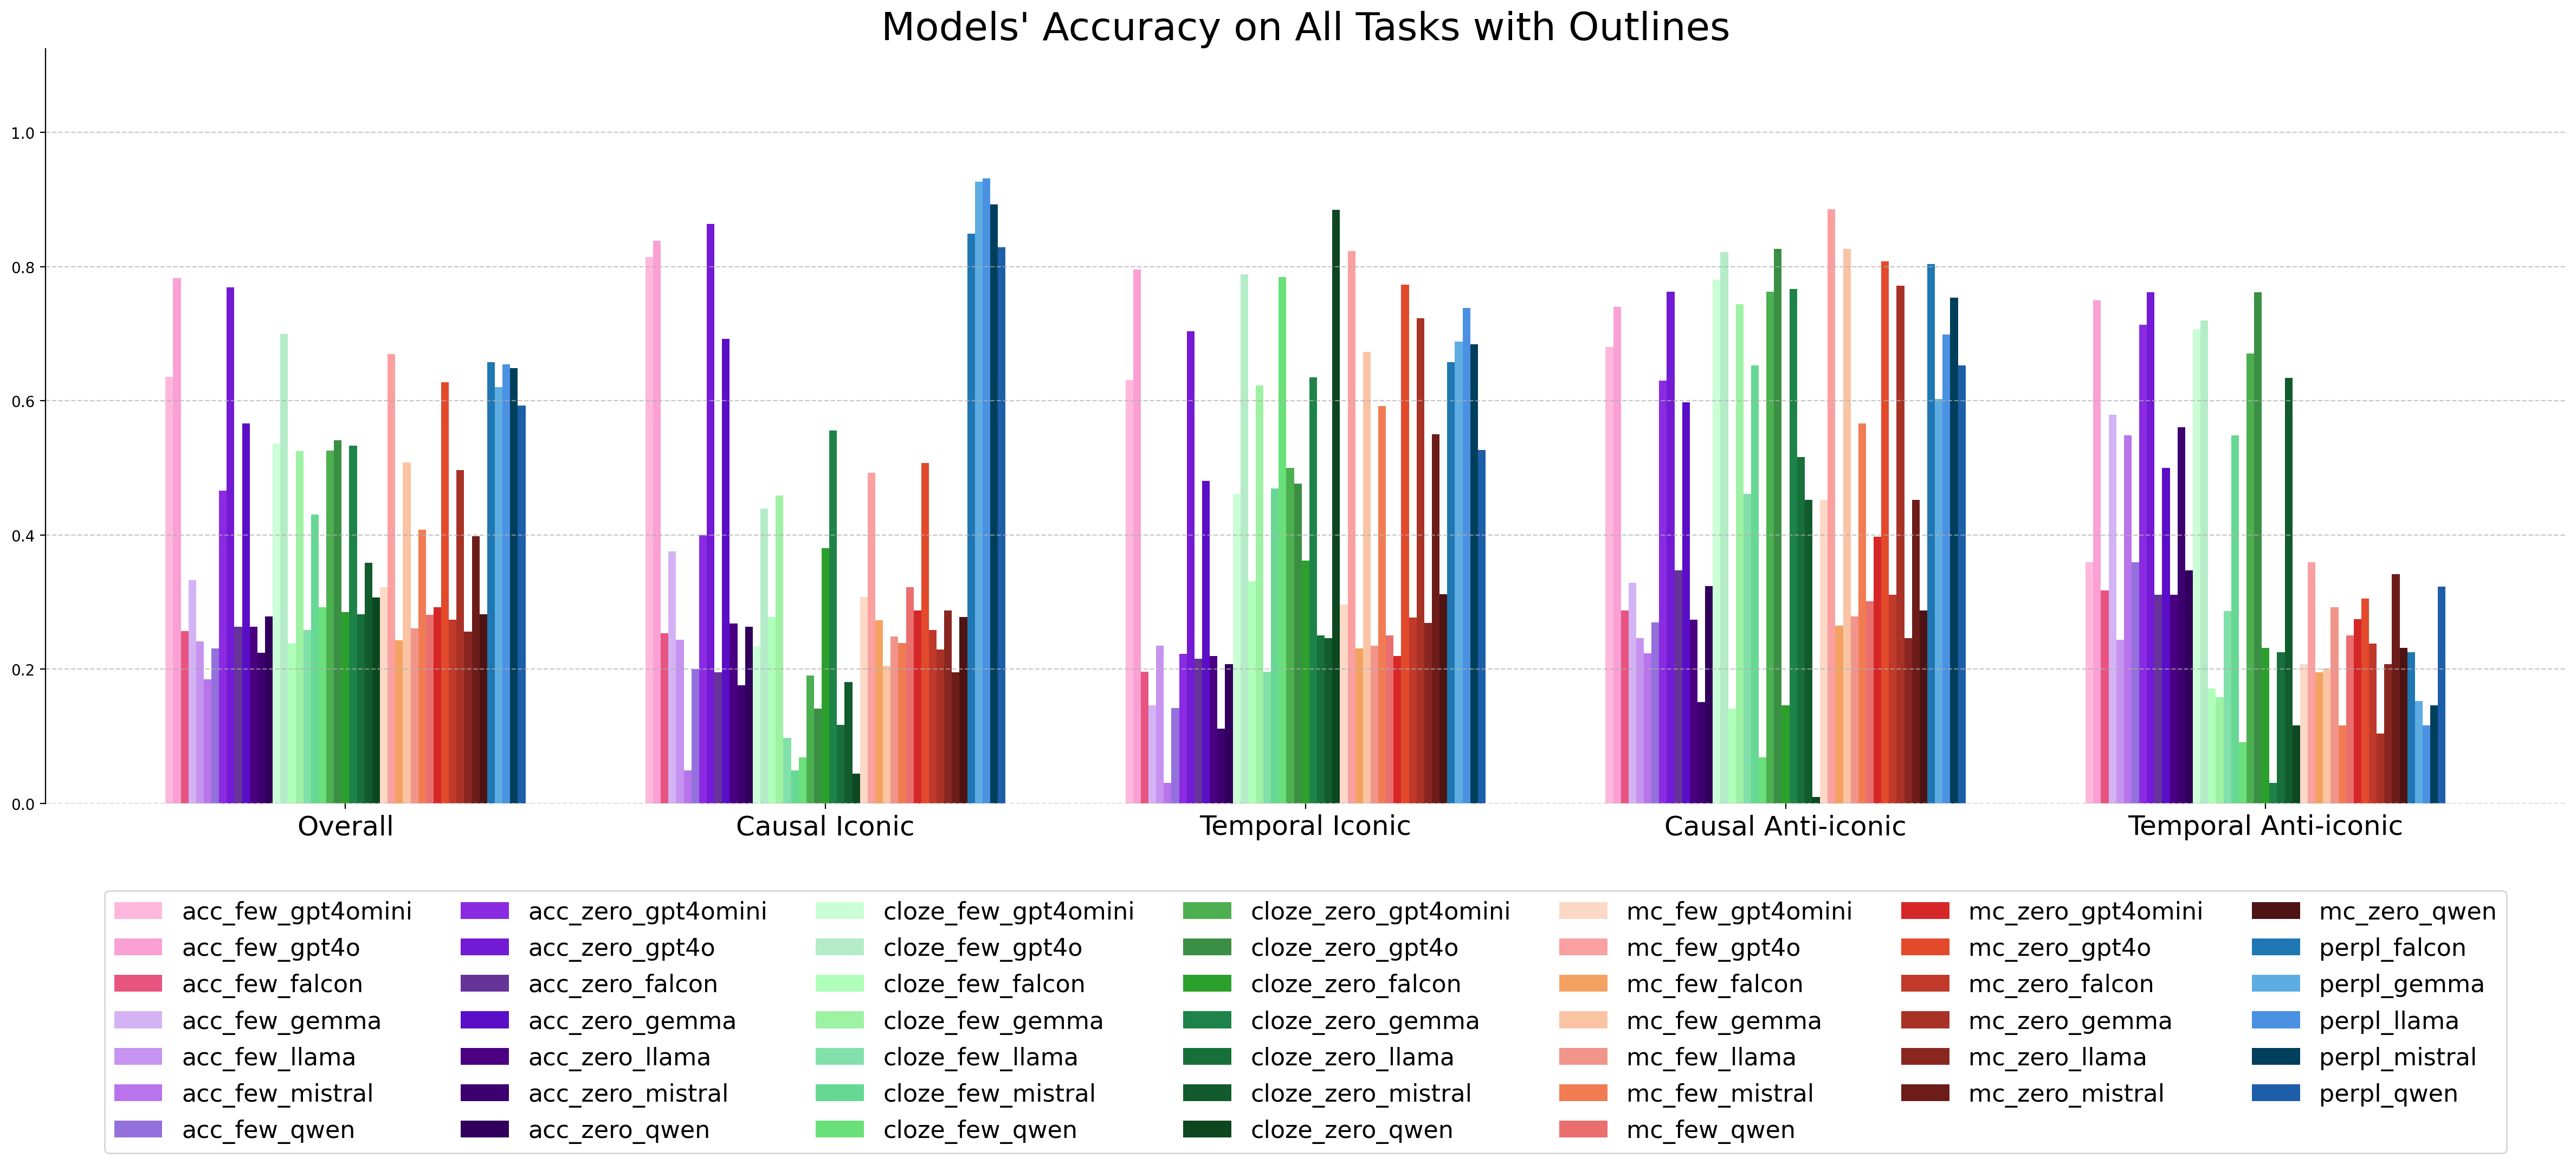

In [16]:
%config InlineBackend.figure_format='retina'  # Ensure high-resolution figures for better visualization


# Dictionary mapping task identifiers to their readable labels
group_labels = {
    "acc_few": "Accuracy - Few",
    "acc_zero": "Accuracy - Zero",
    "cloze_few": "Cloze - Few",
    "cloze_zero": "Cloze - Zero",
    "mc_few_mc_zer": "MC - Few & Zero",
    "perpl": "Perplexity"
}

# Create the figure and axis for plotting
fig, ax = plt.subplots(figsize=(30, 12))

# Transpose the dataframe and plot as a bar chart
df.T.plot.bar(ax=ax, color=palette, rot=0, ylim=(0, 1.125), width=0.75)

# Dictionary defining labels for x-axis categories
group_answer_dict = {
    "Overall": "",
    "Causality AB": ('Causal', 'Iconic', "SO"),
    "Temporal AB": ('Temporal', 'Iconic', "THEN"),
    "Causality BA": ('Causal', 'Anti-iconic', "BECAUSE"),
    "Temporal BA": ('Temporal', 'Anti-iconic', "AFTER")
}

# Set custom x-axis labels based on the dictionary mapping
ax.set_xticklabels([
    f"{group_answer_dict[item][0]} {group_answer_dict[item][1]}"
    if isinstance(group_answer_dict[item], tuple) else item 
    for item in df.T.index.tolist()
], fontsize=18)

# Customize the plot borders (spines) to improve readability
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)

# Extract legend handles and labels for grouping
handles, labels = ax.get_legend_handles_labels()

# Organize legend entries into categorized groups
from collections import defaultdict
legend_dict = defaultdict(list)
for handle, label in zip(handles, labels):
    for key in group_labels:
        if key in label:
            legend_dict[group_labels[key]].append(handle)

# Adjust figure layout to accommodate the legend below the chart
fig.subplots_adjust(bottom=0.3)

# Add grid lines to improve readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Set the title of the plot
ax.set_title("Models' Accuracy on All Tasks with Outlines", fontsize=26)

# Display the legend at the bottom of the figure
ax.legend(
    handles, labels,
    loc='upper center', bbox_to_anchor=(0.5, -0.1), 
    ncol=7,
    fontsize=16,
)

# Show the final plot
plt.show()
